In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
class Consumer:
    channels = ['facebook', 'youtube', 'email', 'search']
    phases = ['problem recognition', 'information search', 'evaluation of alternatives', 
              'purchase decision', 'purchase', 'repurchase']

    base_effectiveness = np.array([
    [0.05, 0.1, 0.5, 0.0],  # problem recognition
    [0.05, 0.1, 0.5, 0.1],  # information search
    [0.07, 0.08, 0.6, 0.1],  # evaluation of alternatives
    [0.08, 0.05, 0.6, 0.05],  # purchase decision
    [0.09, 0.0, 0.6, 0.1],  # purchase
    [0.1, 0.0, 0.6, 0.1]]) # repurchase

    def __init__(self, uid):
        self.uid = uid
        self.phase = np.random.randint(0,6)
        self.transitions = np.random.uniform(0, 0.1, 6)
        self.channel_phase_suitability = np.random.uniform(0, 0.1, size = [6,4]) + self.base_effectiveness
        self.phase_cooldowns = np.random.randint(0, 8, 6)
        self.phase_cooldowns[5] = np.random.randint(8, 31)
        self.phase_cooldown = 0
        self.channel_preference = np.random.exponential(size=5) # last channel is "not online / no ads"
        self.channel_preference = self.channel_preference/self.channel_preference.sum() 
        
    def see_ad(self, ad_channel):
        clickthrough = False
        purchase = False
        if self.phase_cooldown == 0:
            transition_probability = (self.channel_phase_suitability * self.transitions.reshape(6,1))[self.phase, ad_channel]
            if transition_probability > np.random.random():
                purchase = self.transition()
                if np.random.random() < 0.1:
                    clickthrough = True
            else:
                if np.random.random() < 0.01:
                    clickthrough = True
        return clickthrough, purchase
    
    def day(self, timestamp):
        self.phase_cooldown = np.max([0, self.phase_cooldown - 1])
        today_ads = np.max([0, int(np.random.normal(10, 10))])
        if today_ads == 0:
            return
        ad_channels = np.random.choice(np.arange(5), size=today_ads, p = self.channel_preference)
        ad_channels[np.where([ad_channels==2])[1][1:]] = 4
        timestamps = [timestamp + timedelta(hours = 16 * i/(today_ads)) for i in range(today_ads)]
        
        responses = []
        for idx, ad_channel in enumerate(ad_channels):
            if ad_channel != 4:
            
                row = [self.uid, timestamps[idx].strftime('%Y-%m-%d %H:%M:%S'), self.channels[ad_channel]] + list(self.see_ad(ad_channel))
                row = dict(zip(['uid', 'timestamp', 'channel', 'clickthrough', 'purchase'], row))
                responses.append(row)
        return responses
        
        
    def transition(self):
        purchase = False
        self.phase_cooldown = self.phase_cooldowns[self.phase]
        self.phase += 1
        if 0.9 > np.random.random():
            clickthrough = True
        if self.phase > 4:
            purchase = True
        if self.phase==6:
            self.phase=5
        return purchase
    

In [3]:
#generating our consumers

uids = np.random.choice(np.arange(1000000, 10000000), size=10000)
consumers = [Consumer(uid) for uid in uids]

array(['Female'], dtype='<U6')

array(['Gen Alpha'], dtype='<U9')

In [4]:

responses = []
start = datetime(2021, 1, 1, 8, 0, 0)

for i in range(100):
    day = start + timedelta(days=i)
    print(day.strftime('%Y-%m-%d'))
    for c in consumers:
        response =  c.day(day)
        if response:
            responses.extend(response)

2021-01-01
2021-01-02
2021-01-03
2021-01-04
2021-01-05
2021-01-06
2021-01-07
2021-01-08
2021-01-09
2021-01-10
2021-01-11
2021-01-12
2021-01-13
2021-01-14
2021-01-15
2021-01-16
2021-01-17
2021-01-18
2021-01-19
2021-01-20
2021-01-21
2021-01-22
2021-01-23
2021-01-24
2021-01-25
2021-01-26
2021-01-27
2021-01-28
2021-01-29
2021-01-30
2021-01-31
2021-02-01
2021-02-02
2021-02-03
2021-02-04
2021-02-05
2021-02-06
2021-02-07
2021-02-08
2021-02-09
2021-02-10
2021-02-11
2021-02-12
2021-02-13
2021-02-14
2021-02-15
2021-02-16
2021-02-17
2021-02-18
2021-02-19
2021-02-20
2021-02-21
2021-02-22
2021-02-23
2021-02-24
2021-02-25
2021-02-26
2021-02-27
2021-02-28
2021-03-01
2021-03-02
2021-03-03
2021-03-04
2021-03-05
2021-03-06
2021-03-07
2021-03-08
2021-03-09
2021-03-10
2021-03-11
2021-03-12
2021-03-13
2021-03-14
2021-03-15
2021-03-16
2021-03-17
2021-03-18
2021-03-19
2021-03-20
2021-03-21
2021-03-22
2021-03-23
2021-03-24
2021-03-25
2021-03-26
2021-03-27
2021-03-28
2021-03-29
2021-03-30
2021-03-31
2021-04-01

In [6]:
data = pd.DataFrame(responses)

data.head()

,uid,timestamp,channel,clickthrough,purchase
0,2697588,2021-01-01 08:00:00,facebook,False,False
1,9569845,2021-01-01 08:00:00,email,False,False
2,9569845,2021-01-01 12:00:00,facebook,False,False
3,9569845,2021-01-01 18:00:00,facebook,False,False
4,9569845,2021-01-01 19:00:00,youtube,False,False


In [7]:
#generate the gender of each UID with weight on which gender the user is depending on the 
#channel that they clicked the add.

def gen_gender(size = 1, levels = ['Male','Female'], media = data['channel']):
    if media == 'facebook':
        prob = [0.6, 0.4]
    elif media == 'youtube':
        prob = [0.5, 0.5]
    elif media == 'email':
        prob = [0.7, 0.3]
    elif media == 'search':
        prob = [0.5, 0.5]
        
    arr = np.random.choice(levels, size = size, p = prob)              # decide levels based on input probabilities
    return (arr)

In [8]:
#generate the age of each UID with weight on which gender the user is depending on the 
#channel that they clicked the add.


def gen_age(size = 1, media = data['channel']):
    level = ['Gen Alpha', 'Gen Z', 'Millenial', 'Boomer']
    if media == 'facebook':
        prob = [.1, .2, .3, .4]
    elif media == 'youtube':
        prob = [.7, .1, .1, .1]
    elif media == 'email':
        prob = [.2, .2, .3, .3]
    elif media == 'search':
        prob = [.3, .3, .3, .1]
        
    arr = np.random.choice(level, size = size, p = prob)              # decide levels based on input probabilities
    return (arr)

In [9]:
u = pd.DataFrame({'uid': uids,
                  'gender': gen_gender(size = 10000, levels = ['Male','Female'], media = data['channel'].all()),
                    'age': gen_age(size = 10000, media = data['channel'].all())})

In [10]:
u

,uid,gender,age
0,2697588,Female,Gen Alpha
1,9569845,Female,Gen Alpha
2,4983829,Female,Gen Alpha
3,4279915,Female,Gen Z
4,3446863,Male,Millenial
...,...,...,...
9995,4703199,Male,Millenial
9996,8329028,Female,Boomer
9997,6394154,Female,Boomer
9998,8601367,Male,Gen Alpha


In [11]:
data = pd.merge(data, u, on = 'uid')

data.head()

,uid,timestamp,channel,clickthrough,purchase,gender,age
0,2697588,2021-01-01 08:00:00,facebook,False,False,Female,Gen Alpha
1,2697588,2021-01-02 08:00:00,email,False,False,Female,Gen Alpha
2,2697588,2021-01-02 09:20:00,search,False,False,Female,Gen Alpha
3,2697588,2021-01-02 10:40:00,search,False,True,Female,Gen Alpha
4,2697588,2021-01-02 12:00:00,facebook,False,False,Female,Gen Alpha


In [12]:
# data.to_csv(r'data.csv', header= True)

In [ ]:
data['revenue'] = np.where(data['purchase'] == False, 0, 15)
data.replace({True: 1, False: 0}, inplace = True)
data.head()

In [35]:
pd.DataFrame(responses).shape

(6831021, 5)

In [11]:
channels = data.groupby(['channel'])['revenue'].sum()
channels

channel
email       120
facebook     30
search       75
youtube      45
Name: revenue, dtype: int64

Text(0.5, 1.0, "Each Channel's Revenue")

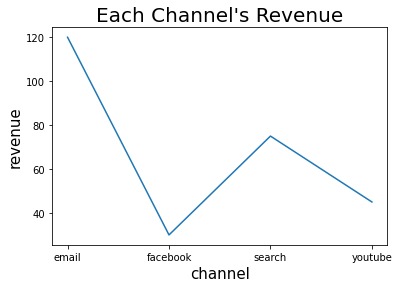

In [12]:
plt.plot(channels)
plt.xlabel('channel', fontsize = 15)
plt.ylabel('revenue', fontsize = 15)
plt.title("Each Channel's Revenue", fontsize = 20)

<AxesSubplot:xlabel='channel,clickthrough'>

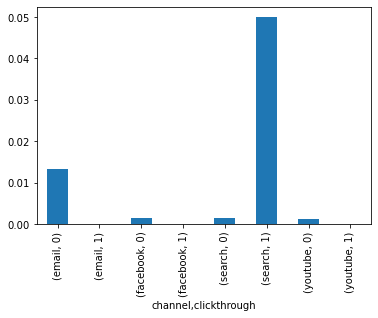

In [13]:
clickthrough = data.groupby(['channel', 'clickthrough'])['purchase'].mean()
clickthrough.plot.bar()

In [14]:
clickthrough

channel   clickthrough
email     0               0.013267
          1               0.000000
facebook  0               0.001509
          1               0.000000
search    0               0.001440
          1               0.050000
youtube   0               0.001129
          1               0.000000
Name: purchase, dtype: float64

In [16]:
gender = data.groupby(['gender', 'channel']).sum()
gender.drop(['uid'], axis = 1, inplace = True)
gender

clickthrough  purchase  revenue
gender channel                                  
Female email                1         5       75
       facebook             1         1       15
       search               5         3       45
       youtube              7         2       30
Male   email                3         3       45
       facebook            10         1       15
       search              15         2       30
       youtube             14         1       15

In [19]:
views = data.groupby(['uid', 'channel'])['timestamp'].count()

views

uid      channel 
1268501  email        69
         facebook     25
         search       70
         youtube     278
2108720  email        22
         facebook    201
         search      142
         youtube     133
2913133  email        50
         search      312
         youtube     225
4464746  email        20
         facebook     81
         search      261
         youtube      34
5333145  email        77
         facebook    239
         search      317
         youtube      11
5336634  email        61
         facebook    262
         search      149
         youtube     423
5697257  email        77
         facebook     85
         search      215
         youtube     272
6364502  email         8
         facebook    166
         search      194
         youtube     553
8067993  email        45
         facebook     62
         search      119
         youtube     514
8270394  email        65
         facebook     44
         search      243
         youtube      28
8444951

In [33]:
u[u['uid'] == 5336634]

,uid,gender,age
1272,5336634,Male,Boomer
